### Principal Component Analysis (PCA)

**PCA** is a powerful technique used for dimensionality reduction in data analysis. To illustrate the concept of PCA, we can use synthetic data generated from a two-dimensional Gaussian distribution.

This distribution is characterized by:  
- The **mean** and **variance** of each dimension.  
- The **covariance** between the two dimensions.

---

### Example Setup

We will visualize data with the following parameters:

- **Mean of each dimension:** 50  
- **Variance along each dimension:** 1  
- **Covariance:** We'll explore two scenarios:  
  1. **Covariance = 0** (uncorrelated dimensions)  
  2. **Covariance = 0.9** (strongly positively correlated dimensions)  

---

### Data Characteristics

1. **Covariance = 0 (Uncorrelated Dimensions):**  
   - The resulting data points form a **circular or spherical pattern**, as the two dimensions are not correlated.  

2. **Covariance = 0.9 (Strong Positive Correlation):**  
   - The data points form an **elongated, elliptical shape**, due to the strong positive correlation between dimensions.  

---

### Implications for PCA

- **Spherical Data (Covariance = 0):**  
  - This type of data is **not ideal** for dimensionality reduction using PCA, as there is no clear direction of maximum variance.  

- **Non-Spherical Data (Covariance = 0.9):**  
  - This elliptical distribution is **well-suited** for PCA, as there is a clear direction of maximum variance that can be exploited for dimensionality reduction.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create_2D_gaussian(mn, variance, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[variance, cov], [cov, variance]]), n)

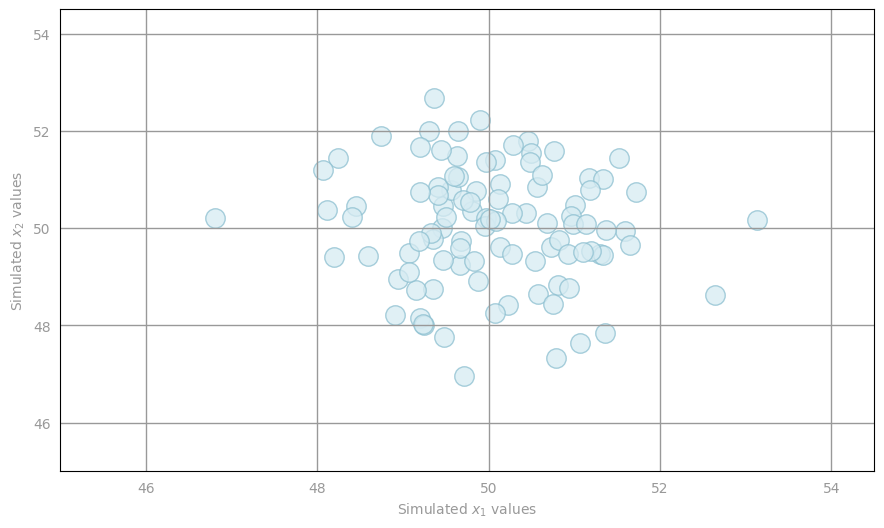

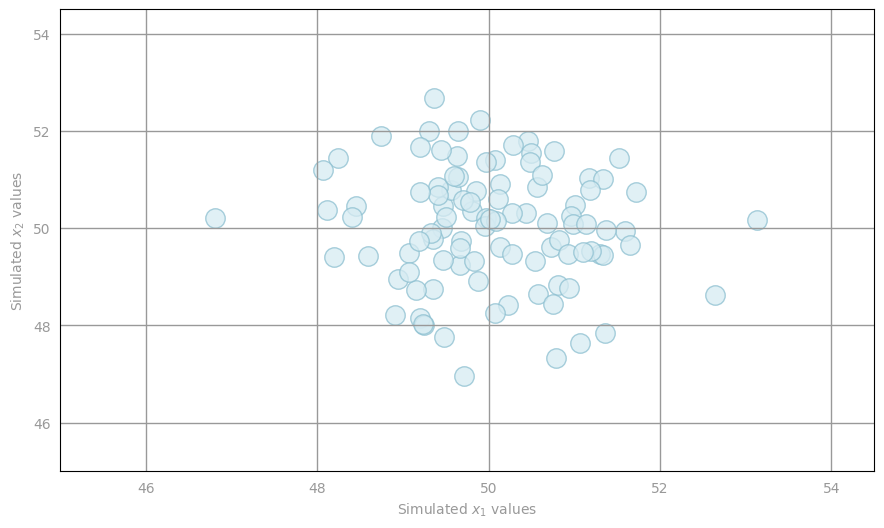

In [ ]:
data_random = create_2D_gaussian(mn=50, variance=1, cov=0, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
display(fig)

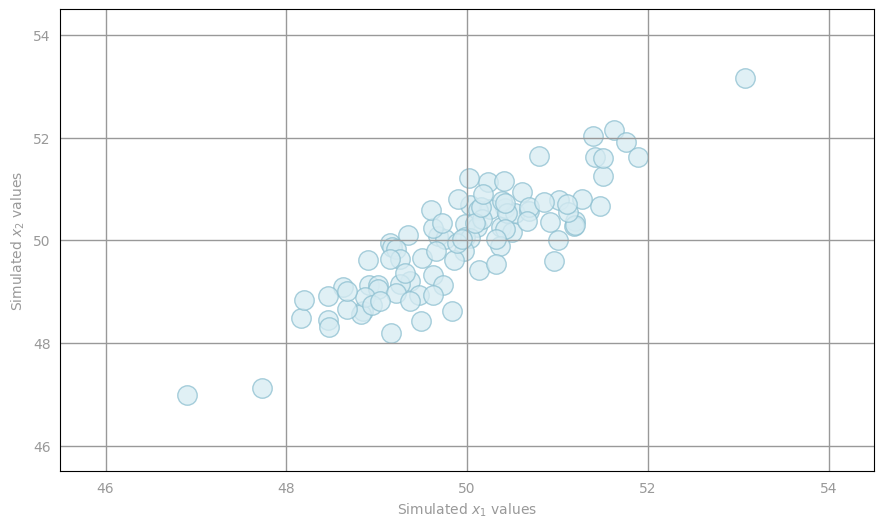

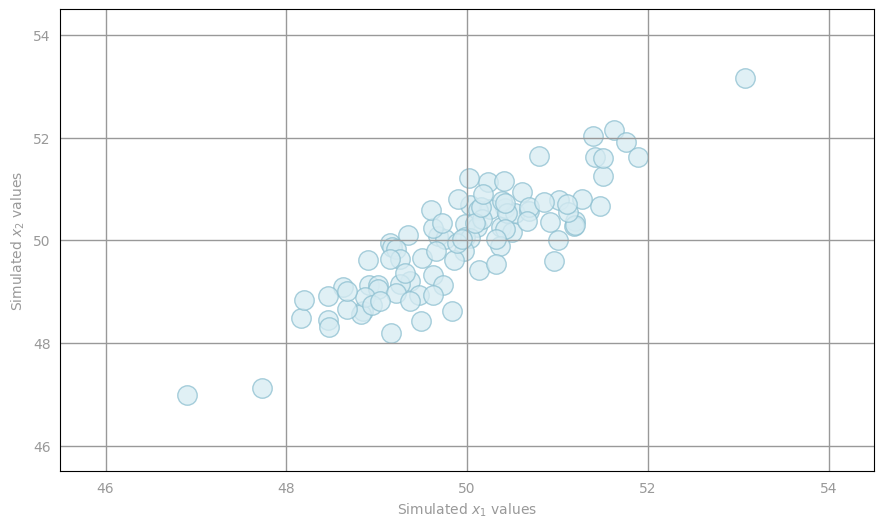

In [ ]:
data_correlated = create_2D_gaussian(mn=50, variance=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
display(fig)

### Understanding PCA  

PCA focuses on finding the "directions" in which the data exhibits the greatest variance. The first step in applying PCA is centering the data. This involves calculating the mean for each feature (column) in the dataset and then adjusting each observation by subtracting the corresponding feature mean. This step ensures that the dataset has a mean of zero for all features.  

#### Important Points:  
- **Dataset:** The correlated dataset is represented as an RDD of NumPy arrays.  
- **Operations:** The RDD format enables efficient computations, such as summing the dataset's columns using `correlated_data.sum()`.

In [ ]:
!pip install pyspark umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from sklearn.manifold import TSNE
import umap
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt


Create a Spark session within Google Colab.

In [ ]:
spark = SparkSession.builder.appName("DimensionalityReductionColab").getOrCreate()


Load the Iris dataset and prepare it for processing.

In [ ]:
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

# Convert Pandas DataFrame to Spark DataFrame
spark_iris_df = spark.createDataFrame(iris_df)

# Show Spark DataFrame
spark_iris_df.show(5)


+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2|      0|
|              4.9|             3.0|              1.4|             0.2|      0|
|              4.7|             3.2|              1.3|             0.2|      0|
|              4.6|             3.1|              1.5|             0.2|      0|
|              5.0|             3.6|              1.4|             0.2|      0|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows



Prepare the dataset by assembling features into vectors and scaling them.

In [ ]:
# Assemble features
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
assembled_data = assembler.transform(spark_iris_df)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Show scaled features
scaled_data.select("scaled_features").show(5)


+--------------------+
|     scaled_features|
+--------------------+
|[-0.8976738791967...|
|[-1.1392004834649...|
|[-1.3807270877331...|
|[-1.5014903898672...|
|[-1.0184371813308...|
+--------------------+
only showing top 5 rows



Apply PCA (Spark Built-In)
Reduce dimensions using PCA from PySpark.




+--------------------+
|        pca_features|
+--------------------+
|[2.25714117564811...|
|[2.07401301519962...|
|[2.35633511180617...|
|[2.29170678586969...|
|[2.38186270441693...|
+--------------------+
only showing top 5 rows



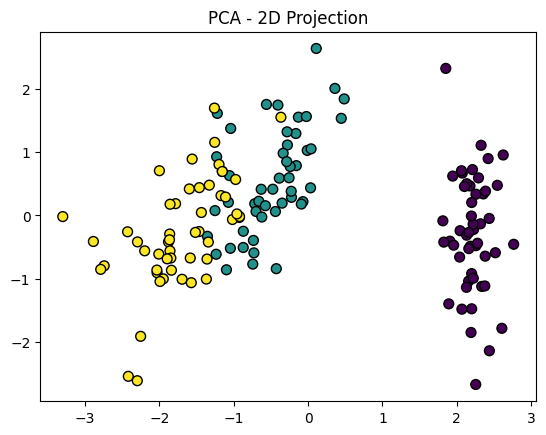

In [ ]:
# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
pca_data = pca_model.transform(scaled_data)

# Show PCA results
pca_data.select("pca_features").show(5)

# Extract and visualize PCA results
pca_features = np.array(pca_data.select("pca_features").rdd.map(lambda row: row[0]).collect())
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=iris.target, cmap='viridis', s=50, edgecolor='k')
plt.title("PCA - 2D Projection")
plt.show()


### Function Overview  

**Input Parameters:**  
- **data:** A matrix containing the dataset.  
- **components:** The principal components calculated from the data.  
- **x_range:** A range of values used to draw lines representing the principal components.  

**Process:**  
1. **Projection:** The data is projected onto the first principal component.  
2. **Line Calculation:** The start and end points of the lines are determined based on the slopes of the first and second principal components.  
3. **Visualization:** The function generates a plot showing the original dataset, the projections, and the principal component lines.  

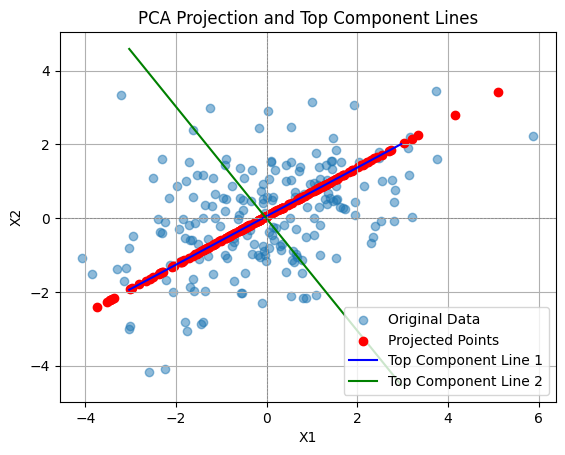

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def project_points_and_get_lines(data, components, x_range):
    """
    Project original data onto the first component and calculate lines for the top two components.

    Args:
        data (np.ndarray): Original data matrix (N x D).
        components (np.ndarray): PCA components matrix (D x D).
        x_range (float): Range for the component lines.

    Returns:
        tuple: (projected points, line details for component 1, line details for component 2).
    """
    # Extract the first principal component
    top_component = components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]  # Slopes of top 2 components

    means = data.mean(axis=0)[:2]  # Mean of first two dimensions
    demeaned = data - means  # Demean the data
    # Project onto the first component
    projected = (demeaned @ top_component)[:, None] * top_component / np.dot(top_component, top_component)
    remeaned = projected + means  # Re-add the mean to get back to the original space
    x1, x2 = remeaned[:, 0], remeaned[:, 1]

    # Calculate line details for the top two components
    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1, x2),
            ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))

# Example usage
def plot_pca_projections(data, x_range=5):
    """
    Perform PCA on the dataset and visualize the projections and top component lines.

    Args:
        data (np.ndarray): Dataset (N x D).
        x_range (float): Range for component lines.
    """
    pca = PCA(n_components=2)
    pca.fit(data)
    components = pca.components_.T  # Transpose to align with original data
    (projected_x, projected_y), line1, line2 = project_points_and_get_lines(data, components, x_range)

    # Scatter plot of original data
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label="Original Data")
    # Scatter plot of projected data
    plt.scatter(projected_x, projected_y, color='red', label="Projected Points")
    # Draw top component lines
    plt.plot(line1[0], line1[1], label="Top Component Line 1", color="blue")
    plt.plot(line2[0], line2[1], label="Top Component Line 2", color="green")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

    plt.title("PCA Projection and Top Component Lines")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid()
    plt.show()

# Generate synthetic 2D data
np.random.seed(42)
data = np.random.multivariate_normal(mean=[0, 0], cov=[[3, 1], [1, 2]], size=200)

# Apply the function and visualize
plot_pca_projections(data, x_range=3)


### Synthetic Data Generation and PCA Workflow  

**1. Data Generation:**  
- The dataset is created using a multivariate Gaussian distribution with predefined means, variances, and correlations.  

**2. PCA Computation:**  
- The first two principal components are used to define the PCA plane.  
- The third principal component serves as the normal vector to this plane.  

**3. Data Projection:**  
- Data points are projected onto the PCA plane by reconstructing them using the first two principal components.  

**4. PCA Plane Grid:**  
- A mesh grid (`xx, yy`) is generated to represent the PCA plane, and the corresponding `z` values are calculated using the normal vector.  

**5. Visualization:**  
- **Plot 1:** Displays the original dataset with the PCA plane superimposed.  
- **Plot 2:** Visualizes the data after projection onto the PCA plane.  

<ipython-input-11-0c8d418893ff>:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_threeD = np.random.multivariate_normal(mu, cov_matrix, 200)
<ipython-input-11-0c8d418893ff>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Blues")


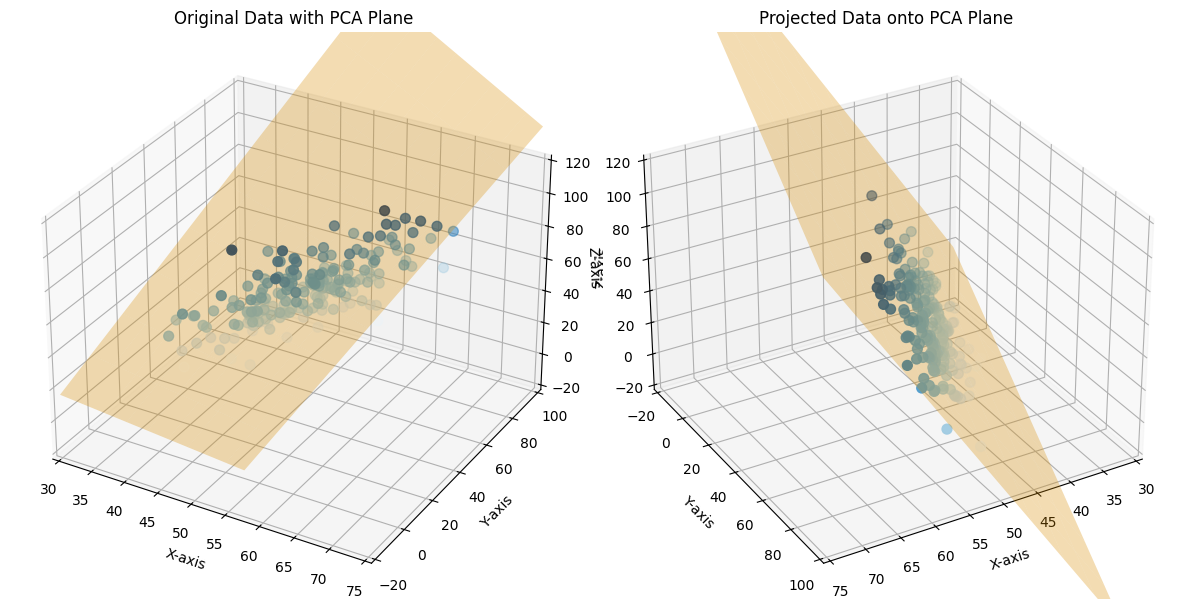

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# Generate synthetic 3D data
np.random.seed(42)
mu = np.array([50, 50, 50])  # Mean
sigma1, sigma2, sigma3 = 5, 20, 20  # Standard deviations
r1_2, r1_3, r2_3 = 0.9, 0.7, 0.1  # Correlations
cov_matrix = np.array([[sigma1**2, r1_2*sigma1*sigma2, r1_3*sigma1*sigma3],
                       [r1_2*sigma1*sigma2, sigma2**2, r2_3*sigma2*sigma3],
                       [r1_3*sigma1*sigma3, r2_3*sigma2*sigma3, sigma3**2]])
data_threeD = np.random.multivariate_normal(mu, cov_matrix, 200)

# Perform PCA
pca = PCA(n_components=3)
pca.fit(data_threeD)
components = pca.components_
normal = components[2]  # Normal vector to the PCA plane

# Project data onto PCA plane
data_mean = data_threeD.mean(axis=0)
demeaned_data = data_threeD - data_mean
projected_data = demeaned_data @ components[:2].T @ components[:2] + data_mean

# Normalize colors for scatter points
norm = Normalize()
cmap = get_cmap("Blues")
clrs = cmap(norm(data_threeD[:, 2]))[:, :3]

# Create grid for PCA plane
xx, yy = np.meshgrid(np.linspace(30, 75, 10), np.linspace(-20, 100, 10))
z = (-normal[0] * (xx - data_mean[0]) - normal[1] * (yy - data_mean[1])) / normal[2] + data_mean[2]

# Plot original data and PCA plane in 3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data_threeD[:, 0], data_threeD[:, 1], data_threeD[:, 2], c=clrs, s=50, label="Original Data")
ax.plot_surface(xx, yy, z, alpha=0.3, color='orange', label="PCA Plane")
ax.set_title("Original Data with PCA Plane")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_xlim([30, 75])
ax.set_ylim([-20, 100])
ax.set_zlim([-20, 120])
ax.view_init(elev=30, azim=-60)

# Plot projections onto PCA plane
ax = fig.add_subplot(122, projection='3d')
ax.scatter(projected_data[:, 0], projected_data[:, 1], projected_data[:, 2], c=clrs, s=50, label="Projected Data")
ax.plot_surface(xx, yy, z, alpha=0.3, color='orange', label="PCA Plane")
ax.set_title("Projected Data onto PCA Plane")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_xlim([30, 75])
ax.set_ylim([-20, 100])
ax.set_zlim([-20, 120])
ax.view_init(elev=30, azim=60)

plt.tight_layout()
plt.show()
